<a href="https://colab.research.google.com/github/Abdelfattah6223/MLGuide/blob/master/Simple_LDA_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importation des librairies

import numpy as np
import pylab as pl
import scipy as sp

In [0]:
!wget https://remi.flamary.com/cours/tds_ml/digits.npz

--2020-05-30 23:40:25--  https://remi.flamary.com/cours/tds_ml/digits.npz
Resolving remi.flamary.com (remi.flamary.com)... 213.186.33.19, 2001:41d0:1:1b00:213:186:33:19
Connecting to remi.flamary.com (remi.flamary.com)|213.186.33.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3533382 (3.4M)
Saving to: ‘digits.npz’

digits.npz          100%[===================>]   3.37M  1.89MB/s    in 1.8s    

2020-05-30 23:40:28 (1.89 MB/s) - ‘digits.npz’ saved [3533382/3533382]



In [0]:
# Chargement des données et pré-traitement

digits = np.load('digits.npz')
x , xt = digits['x'] , digits['xt']
y , yt = digits['y'] , digits['yt']

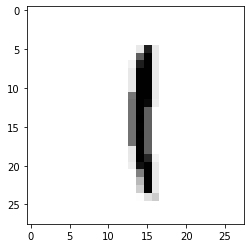

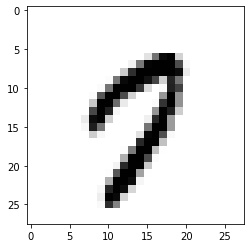

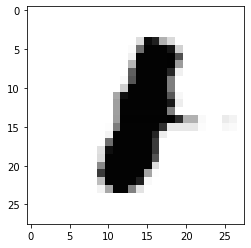

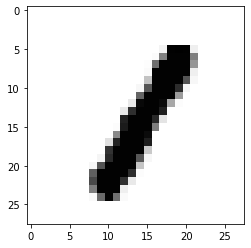

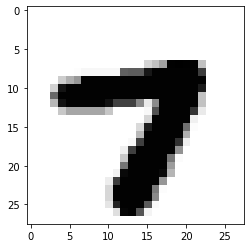

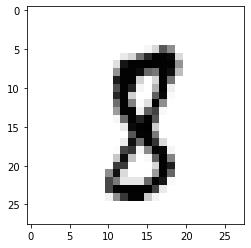

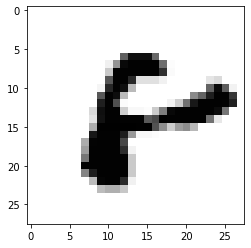

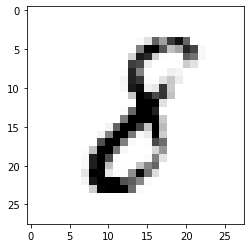

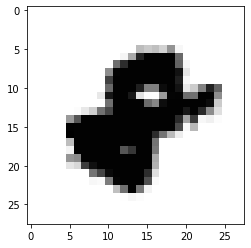

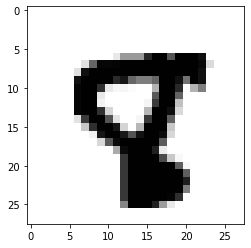

In [0]:
#Afficher 10 images d'une maniere alétoire
random_digits = np.random.randint(0,x.shape[0],size=10)
for i in random_digits:
    img = x[i].T.reshape((28,28))
    pl.imshow(img, cmap="Greys")
    pl.show()


In [0]:
def centrer_reduire(X):

    M = np.mean(X,axis=0)
    sigma = np.std(X,axis=0)
    X = X-M
    for i in range(X.shape[1]):
        if sigma[i] != 0 :
            X[i] = X[i]/sigma[i]
    return X

x_nor = centrer_reduire(x)
xt_nor = centrer_reduire(xt)

In [0]:
# Discrimination binaire
''' 
Dans cette partie on va construire un problème de classifiaction
binaire 8 contre 1 et 7 mais pour choisir un autre problème il suffit
de modifier d1 , d2 et d3 (ici d1 contre d1 et d3),
par exemple pour la question : Refaire les étapes précédentes pour la détection de 1 contre 7 et 8 et 7 contre 1 et 8.
Quelles sont les différences de performance ? A quoi sont-elles dues ?
'''


def clf_binaire(Y,d1,d2,d3):


    Yb = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        if Y[i] == d1 :
            Yb[i] = -1
        else : Yb[i] = 1
    return Yb

yb , ytb = clf_binaire(y,8,1,7) , clf_binaire(yt,8,1,7)  #  classification binaire : 8 contre 1 et 7

In [0]:
# Estimation de p+ et p- :

nbr_un = (yb==1).sum()
nbr_moins_un = (yb==-1).sum()

p_pos , p_neg = nbr_un/len(yb) ,nbr_moins_un/len(yb) # ou tt simplement p_neg = 1 - p_pos
print(p_pos , p_neg)

0.6666666666666666 0.3333333333333333


In [0]:
# Estimation des moyennes mu_pos et mu_neg

''' Diviser les exemples d'apprentissage (centrés-réduits) selon la classe'''
x_c1 , x_c2 = np.zeros((nbr_un,x.shape[1])) , np.zeros((nbr_moins_un,x.shape[1]))
c1 , c2 = 0 , 0
for i in range(x.shape[0]):
    if yb[i]==1 :
        x_c1[c1,:] = x_nor[i,:]
        c1 += 1
    else :
        x_c2[c2,:] = x_nor[i,:]
        c2 += 1


mu_pos = np.mean(x_c1,axis=0)
mu_neg = np.mean(x_c2,axis=0)

In [0]:
# Estimation de Σ

x_c1 = x_c1 - mu_pos
x_c2 = x_c2 - mu_neg


Σ_1 = np.cov(x_c1.T)
Σ_2 = np.cov(x_c2.T)
'''print(Σ_1==Σ_2) # Juste pour vérifier l'hypothése '''

Σ = Σ_1
print(Σ.shape)

(784, 784)


In [0]:
# w et b

mu_diff = np.atleast_1d(mu_pos - mu_neg)

def lda_regularise(lmbda):

    I = np.identity(Σ.shape[0])

    w = np.linalg.pinv(Σ+lmbda*I).dot(mu_diff)
    b = (-1/2)*(w).dot((mu_pos+mu_neg).T) + np.log(p_pos) - np.log(p_neg)
    return w,b

w , b = lda_regularise(0) # sans régularisation ( si on choisit un paramètre de régularisation non nul ( 1,2,10,100 ...) on remarque que le taux de bonne reconnaissance varie (dans la plupart des cas augmente)) Essayer de choisir par exemple 100 ou meme 1000

# Si on ne régularise pas, on n'a pas le garantie que Σ soit inversible (donc il faut choisir lambda tq Σ+lambda*I soit inversible)

In [0]:
# Prediction des classes :

def f(x):
    return (x.T).dot(w)+b
def predire(X):

    ypred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        if f(X[i])<0 : ypred[i] = -1
        else : ypred[i] = 1

    return ypred

ypred_app = predire(x)  # predictions sur les exemples d'apprentissage
ypred_t = predire(xt)   # predictions sur les exemples de test


In [0]:
def taux(Y,Ypred) :

    c = 0
    for i in range(Y.shape[0]):
        if Y[i] == Ypred[i] : c+=1

    return c/Y.shape[0]

taux_app , taux_test = taux(yb,ypred_app) , taux(ytb,ypred_t)
print("le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est : ",taux_app*100)
print("le taux de bonne reconnaissance (en %) pour les exemples de test est : ",taux_test*100)

le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est :  69.43333333333334
le taux de bonne reconnaissance (en %) pour les exemples de test est :  69.06666666666666


In [0]:
# Interpretation : D'abord sans régularisation les taux vont 69.43333333333334 % et 69.06666666666666 % ils sont presque identiques donc il n'y a pas de 'overfitting', mais ils restent un peu faibles.





In [0]:
# Effet de régularisation sur les performances : voir un commentaire précédent.

w , b = lda_regularise(100) 

# Prediction des classes :

def f(x):
    return (x.T).dot(w)+b
def predire(X):

    ypred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        if f(X[i])<0 : ypred[i] = -1
        else : ypred[i] = 1

    return ypred

ypred_app = predire(x)  # predictions sur les exemples d'apprentissage
ypred_t = predire(xt)   # predictions sur les exemples de test

def taux(Y,Ypred) :

    c = 0
    for i in range(Y.shape[0]):
        if Y[i] == Ypred[i] : c+=1

    return c/Y.shape[0]

taux_app , taux_test = taux(yb,ypred_app) , taux(ytb,ypred_t)
print("le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est : ",taux_app*100)
print("le taux de bonne reconnaissance (en %) pour les exemples de test est : ",taux_test*100)


le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est :  96.89999999999999
le taux de bonne reconnaissance (en %) pour les exemples de test est :  94.93333333333334


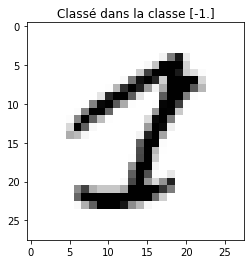

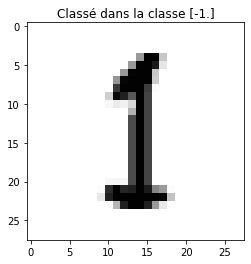

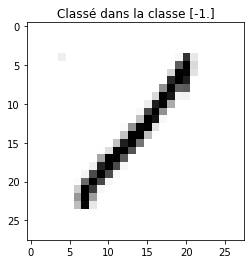

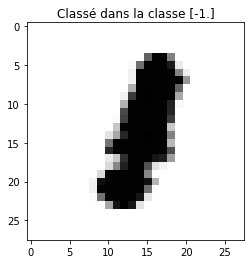

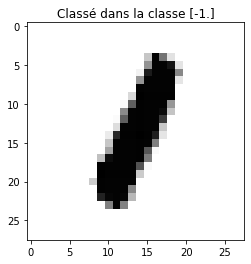

In [0]:
# Visualiser qlq exemples mal classés :

def mal_classe(X,Y,Ypred,nbr_exemples) :

    c = 0
    for i in range(Y.shape[0]):
        if Ypred[i] != Y[i] :

            img = X[i].T.reshape((28,28))
            pl.title("Classé dans la classe "+str(Ypred[i]))
            pl.imshow(img, cmap="Greys")
            pl.show()
            c += 1
        if c == nbr_exemples : break

mal_classe(x,yb,ypred_app,5) 

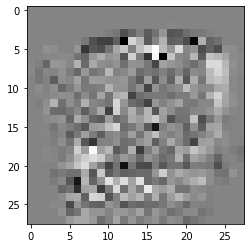

In [0]:
# Visualiser le classifieur w sous la forme d’une image, interpréter.


pl.imshow(w.reshape((28,28)), cmap="Greys")
pl.show()


In [0]:
# Classification binaire : 1 contre 7 et 8

yb , ytb = clf_binaire(y,1,7,8) , clf_binaire(yt,1,7,8)

# Estimation de p+ et p- :

nbr_un = (yb==1).sum()
nbr_moins_un = (yb==-1).sum()

p_pos , p_neg = nbr_un/len(yb) ,nbr_moins_un/len(yb)

# Estimation des moyennes mu_pos et mu_neg

''' Diviser les exemples d'apprentissage (centrés-réduits) selon la classe'''
x_c1 , x_c2 = np.zeros((nbr_un,x.shape[1])) , np.zeros((nbr_moins_un,x.shape[1]))
c1 , c2 = 0 , 0
for i in range(x.shape[0]):
    if yb[i]==1 :
        x_c1[c1,:] = x_nor[i,:]
        c1 += 1
    else :
        x_c2[c2,:] = x_nor[i,:]
        c2 += 1


mu_pos = np.mean(x_c1,axis=0)
mu_neg = np.mean(x_c2,axis=0)

# Estimation de Σ
x_c1 = x_c1 - mu_pos
x_c2 = x_c2 - mu_neg


Σ_1 = np.cov(x_c1.T)
Σ_2 = np.cov(x_c2.T)
'''print(Σ_1==Σ_2) # Juste pour vérifier l'hypothése '''

Σ = Σ_1

# w et b

mu_diff = np.atleast_1d(mu_pos - mu_neg)

def lda_regularise(lmbda):

    I = np.identity(Σ.shape[0])

    w = np.linalg.pinv(Σ+lmbda*I).dot(mu_diff)
    b = (-1/2)*(w).dot((mu_pos+mu_neg).T) + np.log(p_pos) - np.log(p_neg)
    return w,b

w , b = lda_regularise(100)

# Prediction des classes :

def f(x):
    return (x.T).dot(w)+b
def predire(X):

    ypred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        if f(X[i])<0 : ypred[i] = -1
        else : ypred[i] = 1

    return ypred

ypred_app = predire(x)  # predictions sur les exemples d'apprentissage
ypred_t = predire(xt)   # predictions sur les exemples de test

def taux(Y,Ypred) :

    c = 0
    for i in range(Y.shape[0]):
        if Y[i] == Ypred[i] : c+=1

    return c/Y.shape[0]

taux_app , taux_test = taux(yb,ypred_app) , taux(ytb,ypred_t)
print("le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est : ",taux_app*100)
print("le taux de bonne reconnaissance (en %) pour les exemples de test est : ",taux_test*100)




le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est :  94.8
le taux de bonne reconnaissance (en %) pour les exemples de test est :  91.0


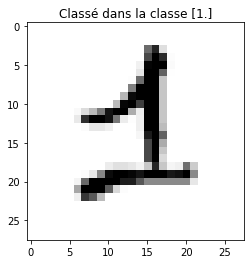

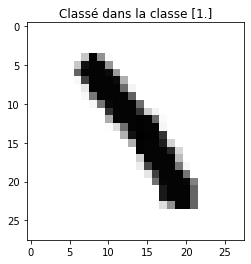

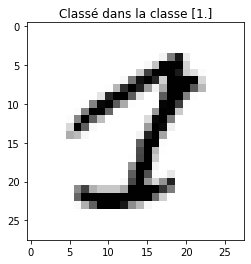

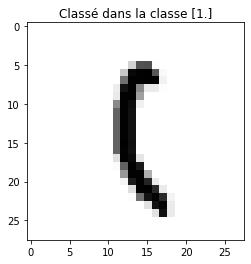

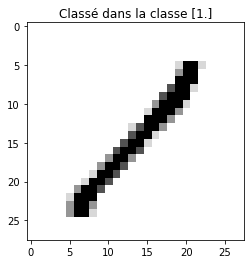

In [0]:
# Visualiser qlq exemples mal classés :

def mal_classe(X,Y,Ypred,nbr_exemples) :

    c = 0
    for i in range(Y.shape[0]):
        if Ypred[i] != Y[i] :

            img = X[i].T.reshape((28,28))
            pl.title("Classé dans la classe "+str(Ypred[i]))
            pl.imshow(img, cmap="Greys")
            pl.show()
            c += 1
        if c == nbr_exemples : break

mal_classe(x,yb,ypred_app,5) 

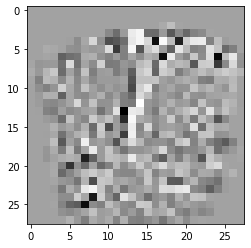

In [0]:
# Visualiser le classifieur w sous la forme d’une image, interpréter.


pl.imshow(w.reshape((28,28)), cmap="Greys")
pl.show()

In [0]:
# Classification binaire : 1 contre 7 et 8

yb , ytb = clf_binaire(y,7,1,8) , clf_binaire(yt,7,1,8)

# Estimation de p+ et p- :

nbr_un = (yb==1).sum()
nbr_moins_un = (yb==-1).sum()

p_pos , p_neg = nbr_un/len(yb) ,nbr_moins_un/len(yb)

# Estimation des moyennes mu_pos et mu_neg

''' Diviser les exemples d'apprentissage (centrés-réduits) selon la classe'''
x_c1 , x_c2 = np.zeros((nbr_un,x.shape[1])) , np.zeros((nbr_moins_un,x.shape[1]))
c1 , c2 = 0 , 0
for i in range(x.shape[0]):
    if yb[i]==1 :
        x_c1[c1,:] = x_nor[i,:]
        c1 += 1
    else :
        x_c2[c2,:] = x_nor[i,:]
        c2 += 1


mu_pos = np.mean(x_c1,axis=0)
mu_neg = np.mean(x_c2,axis=0)

# Estimation de Σ
x_c1 = x_c1 - mu_pos
x_c2 = x_c2 - mu_neg


Σ_1 = np.cov(x_c1.T)
Σ_2 = np.cov(x_c2.T)
'''print(Σ_1==Σ_2) # Juste pour vérifier l'hypothése '''

Σ = Σ_1

# w et b

mu_diff = np.atleast_1d(mu_pos - mu_neg)

def lda_regularise(lmbda):

    I = np.identity(Σ.shape[0])

    w = np.linalg.pinv(Σ+lmbda*I).dot(mu_diff)
    b = (-1/2)*(w).dot((mu_pos+mu_neg).T) + np.log(p_pos) - np.log(p_neg)
    return w,b

w , b = lda_regularise(100)

# Prediction des classes :

def f(x):
    return (x.T).dot(w)+b
def predire(X):

    ypred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        if f(X[i])<0 : ypred[i] = -1
        else : ypred[i] = 1

    return ypred

ypred_app = predire(x)  # predictions sur les exemples d'apprentissage
ypred_t = predire(xt)   # predictions sur les exemples de test

def taux(Y,Ypred) :

    c = 0
    for i in range(Y.shape[0]):
        if Y[i] == Ypred[i] : c+=1

    return c/Y.shape[0]

taux_app , taux_test = taux(yb,ypred_app) , taux(ytb,ypred_t)
print("le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est : ",taux_app*100)
print("le taux de bonne reconnaissance (en %) pour les exemples de test est : ",taux_test*100)




le taux de bonne reconnaissance (en %) pour les exemples d'apprentissage est :  93.73333333333333
le taux de bonne reconnaissance (en %) pour les exemples de test est :  90.53333333333333


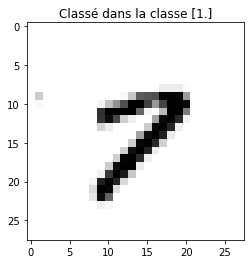

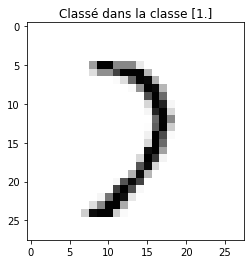

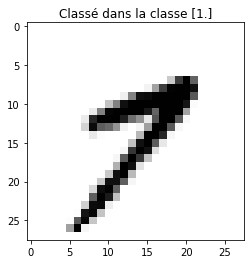

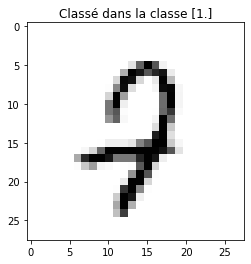

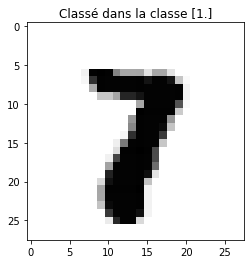

In [0]:
# Visualiser qlq exemples mal classés :

def mal_classe(X,Y,Ypred,nbr_exemples) :

    c = 0
    for i in range(Y.shape[0]):
        if Ypred[i] != Y[i] :

            img = X[i].T.reshape((28,28))
            pl.title("Classé dans la classe "+str(Ypred[i]))
            pl.imshow(img, cmap="Greys")
            pl.show()
            c += 1
        if c == nbr_exemples : break

mal_classe(x,yb,ypred_app,5) 

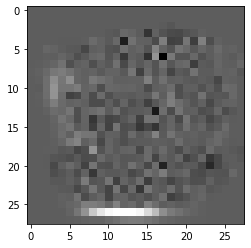

In [0]:
# Visualiser le classifieur w sous la forme d’une image, interpréter.


pl.imshow(w.reshape((28,28)), cmap="Greys")
pl.show()

In [0]:
'''
Interpretation : les differences de performance peut etre dues au fait 1 e 7 
sont un peu similaires dans leur ecriture et quand  se trouvent dans des classes 
differents cette similarité engendre plus d'erreur.
'''

In [0]:
# Discrimination multiclasse ("un contre tous")
'''
D'après ce qui précéde :
- la classification binaire (avec un paramétre de régularisation de 100) sur 8 contre 1 et 7 donne :
    un taux de bonne reconnaissance pour les exemples d'apprentissage  de 96.89999999999999 %
    un taux de bonne reconnaissance pour les exemples de test de 94.93333333333334 %
- la classification binaire (avec un paramétre de régularisation de 100) sur 1 contre 7 et 8 donne :
    un taux de bonne reconnaissance pour les exemples d'apprentissage  de 94.8 %
    un taux de bonne reconnaissance pour les exemples de test de 91.0 %
- la classification binaire (avec un paramétre de régularisation de 100) sur 7 contre 1 et 8 donne :
    un taux de bonne reconnaissance pour les exemples d'apprentissage de 93.73333333333333 %
    un taux de bonne reconnaissance pour les exemples de test est de 90.53333333333333 %

La prédiction finale consiste à choisir la classe qui a le score le plus important c'est-à-dire : la classe 8 (8 contre 1 et 7 )

'''